# OCR Prototypes

Rerun the first code cell to reload the files if new files are added

In [19]:
# Install the ipynb package
#%pip install ipynb

# Base code for all notebooks in the same folder
from ipynb.fs.full.common import setup, reload_packages # type: ignore

files = []
files = setup()

print(f"Number of files: {len(files)}")

Common Files Setup()
Looking for files in /Users/tedbouskill/Repos/MyGitHub/wordscape-score-scraper/prototypes/../png_samples
Number of files: 10


## Reload Packages()

Rerun the cell below this one to reload common packages in repo_packages or workspace_packages if they change

In [42]:

reload_packages()

import cv2 # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pytesseract # type: ignore
import io

from cls_img_tools import ImageTools
from cls_string_helpers import StringHelpers

from PIL import Image, ImageOps, ImageFilter # type: ignore

import os

def no_op():
    pass

def resize_image_pillow(image_path: str, new_width: int=1200):
    with Image.open(image_path) as img:
        original_width, original_height = img.size
        aspect_ratio = original_height / original_width
        new_height = int(aspect_ratio * new_width)

        resized_img = img.resize((new_width, new_height), Image.LANCZOS)
        return resized_img, new_height

def resize_image_opencv(image_path: str, new_width: int = 1200) -> np.ndarray:
    # Read the image
    img = cv2.imread(image_path) #, cv2.IMREAD_UNCHANGED)
    #display_image_opencv(img)

    #image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    # Normalize the 16-bit image to 8-bit
    #image_8bit = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    #display_image_opencv(image_8bit)

    # Get the original dimensions
    original_height, original_width = img.shape[:2]

    # Calculate the new dimensions
    aspect_ratio = original_height / original_width
    new_height = int(aspect_ratio * new_width)

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
    #display_image_opencv(resized_img)

    return resized_img, new_height

def crop_image_opencv(image: np.ndarray, x: int, y: int, width: int, height: int) -> np.ndarray:
    # Crop the image using array slicing
    cropped_img = image[y:y+height, x:x+width]
    return cropped_img

def enhance_image(img, scale=2) -> Image.Image:
    img = img.convert('L')  # Convert the image to grayscale

    # Apply binary thresholding
    img = img.point(lambda x: 0 if x < 225 else 255, '1')

    # Resize the image
    img = img.resize((img.width * scale, img.height * scale), Image.LANCZOS)

    # Sharpen the image
    img = img.filter(ImageFilter.SHARPEN)

    return img

def adjust_gamma(image, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def enhance_image_opencv(img, scale=2) -> np.ndarray:
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 1: Enhance contrast with CLAHE
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #image = clahe.apply(image)

    # Step 2: Apply gamma correction
    image = adjust_gamma(image, gamma=1.5)

    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    return binary

def convert_to_black_and_white(image: np.ndarray, threshold: int = 128) -> np.ndarray:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    return binary

def convert_non_white_to_black_opencv(image, threshold=200):
    """
    Convert non-white pixels to black in the given image using OpenCV.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a mask for pixels that are above the threshold
    mask = gray > threshold

    # Create an output image with the same shape as the input image, initialized to black
    output = np.zeros_like(image)

    # Set the pixels that are above the threshold in the original image to white in the output image
    output[mask] = [255, 255, 255]

    return output

def is_white(pixel, threshold=225):
    r, g, b = pixel
    return r > threshold and g > threshold and b > threshold

def convert_non_white_to_black(image, threshold=225):
    # Ensure the image is in RGB mode
    img = image.convert('RGB')

    # Create a new image with the same size
    new_img = Image.new('RGB', img.size)

    # Process each pixel
    for x in range(img.width):
        for y in range(img.height):
            pixel = img.getpixel((x, y))
            if is_white(pixel):
                new_img.putpixel((x, y), (255, 255, 255))  # Keep white pixels as white
            else:
                new_img.putpixel((x, y), (0, 0, 0))  # Convert non-white pixels to black

    return new_img

def display_image(img, title="Image", rotate=0):
    # Rotate the image 90 degrees clockwise for display
    img = img.rotate(rotate, expand=True)

    # Display the image using matplotlib
    plt.imshow(img)
    plt.title(title)

    plt.axis('off')  # Hide the axis
    plt.show()

def display_image_opencv(img, title="Image"):
    # Display the image using matplotlib
    plt.imshow(img)
    plt.title(title)

    plt.axis('off')  # Hide the axis
    plt.show()


Reloading packages


## Prototypes

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Processing file: /Users/tedbouskill/Repos/MyGitHub/wordscape-score-scraper/prototypes/../png_samples/2024-11-03-06.png
State: TALLYING


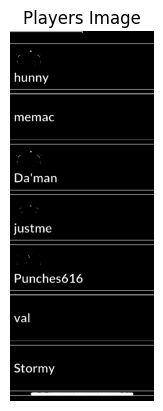

Text: hunny, Box: [[11, 164], [167, 164], [167, 229], [11, 229]], Confidence: 0.9999877915397694
Text: memac, Box: [[16, 340], [189, 340], [189, 383], [16, 383]], Confidence: 0.9985867938155958
Text: Da'man, Box: [[14, 587], [200, 587], [200, 640], [14, 640]], Confidence: 0.9992443808282165
Text: justme, Box: [[5, 789], [182, 789], [182, 858], [5, 858]], Confidence: 0.9995193860628231
Text: Punches616, Box: [[14, 1008], [309, 1008], [309, 1060], [14, 1060]], Confidence: 0.9949982874994889
Text: val, Box: [[11, 1173], [90, 1173], [90, 1224], [11, 1224]], Confidence: 0.9998513383672313
Text: Stormy, Box: [[9, 1381], [192, 1381], [192, 1443], [9, 1443]], Confidence: 0.9874372377684979


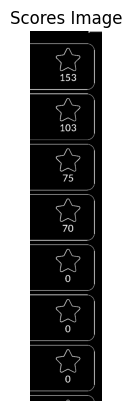

Text: 153, Box: [[121, 173], [197, 173], [197, 214], [121, 214]], Confidence: 0.9283654093742371
Text: 103, Box: [[121, 384], [197, 384], [197, 424], [121, 424]], Confidence: 0.9955467581748962
Text: 75, Box: [[133, 596], [185, 596], [185, 633], [133, 633]], Confidence: 0.9999934250979631
Text: 70, Box: [[134, 809], [183, 809], [183, 841], [134, 841]], Confidence: 0.9999531330261343
Tesseract: 3

Length of player results:  7
Length of score results:  4
Min score x:  1200
Text: hunny, Numeric: 153
Text: memac, Numeric: 103
Text: Da'man, Numeric: 75
Text: justme, Numeric: 70
Unmatched:
Text: Punches616, Confidence: 0.9949982874994889
Text: val, Confidence: 0.9998513383672313
Text: Stormy, Confidence: 0.9874372377684979

Processing file: /Users/tedbouskill/Repos/MyGitHub/wordscape-score-scraper/prototypes/../png_samples/2024-09-08-04.png
State: FINISHED
Rank: #3


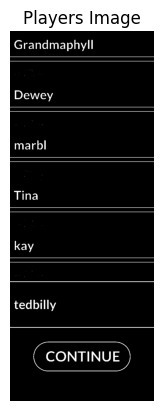

Text: Grandmaphyll, Box: [[10, 30], [355, 30], [355, 93], [10, 93]], Confidence: 0.7549290428340504
Text: Dewey, Box: [[12, 239], [185, 239], [185, 300], [12, 300]], Confidence: 0.9999366351295614
Text: marbl, Box: [[15, 451], [156, 451], [156, 501], [15, 501]], Confidence: 0.9998886304686493
Text: Tina, Box: [[12, 661], [122, 661], [122, 712], [12, 712]], Confidence: 0.9999446868896484
Text: tedbilly, Box: [[7, 1110], [199, 1110], [199, 1177], [7, 1177]], Confidence: 0.9999964175152185
Text: CONTINUE, Box: [[145, 1331], [462, 1331], [462, 1388], [145, 1388]], Confidence: 0.999844978913932
Text: kay, Box: [[16.926687370800103, 867.0967805394006], [108.54934469362577, 879.718602737065], [99.0733126291999, 933.9032194605994], [7.4506553063742285, 921.281397262935]], Confidence: 0.9999106650156214


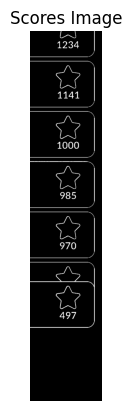

Text: 1234, Box: [[109, 35], [209, 35], [209, 77], [109, 77]], Confidence: 0.9999991655349731
Text: 1141, Box: [[110, 247], [209, 247], [209, 288], [110, 288]], Confidence: 0.9999992847442627
Text: 1000, Box: [[109, 457], [209, 457], [209, 496], [109, 496]], Confidence: 0.9996052384376526
Text: 985, Box: [[120, 667], [196, 667], [196, 707], [120, 707]], Confidence: 0.9999998623489704
Text: 970, Box: [[118, 877], [197, 877], [197, 917], [118, 917]], Confidence: 0.9999979352348233
Text: 497, Box: [[118, 1167], [195, 1167], [195, 1208], [118, 1208]], Confidence: 0.9999993117448777
Tesseract: 2

Length of player results:  6
Length of score results:  6
Min score x:  1200
Text: Grandmaphyll, Numeric: 1234
Text: Dewey, Numeric: 1141
Text: marbl, Numeric: 1000
Text: Tina, Numeric: 985
Text: tedbilly, Numeric: 497
Text: kay, Numeric: 970
Unmatched:



In [49]:
import dis
import easyocr

from re import S
from tokenize import String
from sympy import O # type: ignore

# Initialize EasyOCR
reader = easyocr.Reader(['en'])

min_score_x = 1200

for img_file in files:
    if "reduced" in img_file or "IMG" in img_file:
        continue

    print(f"Processing file: {img_file}")

    img, new_height = resize_image_opencv(img_file)
    #display_image_opencv(img, title="Original Image")

    #img = enhance_image_opencv(img)

    #header_img = img.crop((0, 0, 1200, 1050))
    #display_image(header_img, title="Header Image")

    state_img = crop_image_opencv(img, 450, 680, 300, 100)
    state_img = convert_non_white_to_black_opencv(state_img)
    state_txt = pytesseract.image_to_string(state_img)
    if state_txt is not None:
        state_txt = state_txt.strip()
        print(f"State: {state_txt}")
    #display_image_opencv(state_img, title="State Image")

    # If tournament fininshed, the rank image is present
    if state_txt == "FINISHED":
        rank_img = crop_image_opencv(img, 100, 540, 200, 110)
        rank_img = convert_non_white_to_black_opencv(rank_img)
        rank_txt = pytesseract.image_to_string(rank_img).strip()
        print(f"Rank: {rank_txt}")
        #display_image_opencv(rank_img, title="Rank Image")

    #ranks_img = crop_image_opencv(img, 40, 1000, 110, new_height - 1000)
    #ranks_img = enhance_image_opencv(ranks_img)
    #results = reader.readtext(ranks_img)
    #for box, text, confidence in results:
    #    print(f"Box: {box}, Text: {text}, Confidence: {confidence}")
    #display_image_opencv(ranks_img, title="Ranks Image")

    player_results = []
    score_results = []
    results = []

    players_img = crop_image_opencv(img, 300, 1050, 600, new_height - 1050) # Only player tags
    #players_img = crop_image_opencv(img, 300, 1050, 900, new_height - 1050) # Player and score tags
    players_img = convert_non_white_to_black_opencv(players_img, 225)
    display_image_opencv(players_img, title="Players Image")
    results = reader.readtext(players_img, mag_ratio=2.0)
    for box, text, confidence in results:
        print(f"Text: {text}, Box: {box}, Confidence: {confidence}")
        # If the y is less than 100, then it is the player name
        if box[0][0] < 50:
            player_results.append((box, text, confidence))

        if box[0][0] > 650: # and (StringHelpers.is_all_numeric(text) or "O" in text or "o" in text):
            if box[0][0] < min_score_x:
                min_score_x = box[0][0]
            score_results.append((box, text, confidence))

    scores_img = crop_image_opencv(img, 900, 1050, 300, new_height - 1050)
    scores_img = convert_non_white_to_black_opencv(scores_img, 222)
    scores_img = adjust_gamma(scores_img, gamma=5.1)
    display_image_opencv(scores_img, title="Scores Image")
    #results = reader.detect(scores_img, mag_ratio=4.0)
    #for bbox in results[0]:
    #    print(bbox)  # Print bounding boxes to check if zeros are detected

    results = reader.readtext(scores_img, detail=1, mag_ratio=4.0, allowlist="0123456789oO", blocklist=".,!@#$%^&*()")
    for box, text, confidence in results:
        print(f"Text: {text}, Box: {box}, Confidence: {confidence}")
        score_results.append((box, text, confidence))
    tesseract_results = pytesseract.image_to_string(scores_img, config='--psm 7 -c tessedit_char_whitelist=0123456789Oo')
    print(f"Tesseract: {tesseract_results}")

    print("Length of player results: ", len(player_results))
    print("Length of score results: ", len(score_results))
    print("Min score x: ", min_score_x)

     # Match numeric values with text values based on y-coordinate
    matches = []
    unmatched = []
    for text_box, text, text_confidence in player_results:
        text_y = text_box[0][1]  # y-coordinate of the top-left corner of the text box
        matched = False
        for num_box, num_text, num_confidence in score_results:
            num_y = num_box[0][1]  # y-coordinate of the top-left corner of the numeric box
            if 0 < abs(num_y - text_y) < 65:
                matches.append((text, num_text))
                matched = True
                break
        if not matched:
            unmatched.append((text, text_confidence))

    # Print matched results
    for text, num in matches:
        print(f"Text: {text}, Numeric: {num}")

    # Print unmatched results
    print("Unmatched:")
    for text, confidence in unmatched:
        print(f"Text: {text}, Confidence: {confidence}")

    #display_image_opencv(players_img, title="Players Image")

    #with img.crop((40, 1000, 150, new_height)) as ranks_img:
    #    tmp_ranks_imag_path = "temp_ranks_image.png"
    #    ranks_img.save(tmp_ranks_imag_path)
    #    results = reader.readtext(tmp_ranks_imag_path)
    #    for box, text, confidence in results:
    #        print(f"Box: {box}, Text: {text}, Confidence: {confidence}")
    #    #display_image(ranks_img, title="Ranks Image")
    #    os.remove(tmp_ranks_imag_path)

    #with img.crop((300, 1050, 1200, new_height)) as players_img:
    #    players_img = convert_non_white_to_black(players_img)
    #    tmp_players_imag_path = "temp_players_image.png"
    #    players_img.save(tmp_players_imag_path)
    #    players_results = reader.readtext(tmp_players_imag_path)
    #    for box, text, confidence in players_results:
    #        print(f"Box: {box}, Text: {text}, Confidence: {confidence}")
    #    #print(f"Players: {players_text}")
    #    display_image(players_img, title="Players Image")

    #scores_img = img.crop((980, 1050, 1150, new_height))
    #display_image(scores_img, title="Scores Image")

    print()


In [23]:
import easyocr
import re

import cls_string_helpers as StringHelpers

from fuzzywuzzy import fuzz, process
from hmac import new

def get_min_max_values(boxes):
    if not boxes:
        return None, None, None, None

    min_height = min(min(box[0][1], box[1][1], box[2][1], box[3][1]) for box in boxes)
    min_width = min(min(box[0][0], box[1][0], box[2][0], box[3][0]) for box in boxes)
    max_height = max(max(box[0][1], box[1][1], box[2][1], box[3][1]) for box in boxes)
    max_width = max(max(box[0][0], box[1][0], box[2][0], box[3][0]) for box in boxes)

    return min_height, min_width, max_height, max_width

# Initialize EasyOCR
reader = easyocr.Reader(['en'])

tt_ds = set()
ts_dims = set()
team_rank_dims = set()
teammates_dims = set()
first_dims = set()
second_dims = set()
third_dims = set()
scores_dims = set()

max_image_heights = []
unique_strings = set()
unique_uppercase_strings = set()

for img_file in files:
    temp_path, new_height = resize_image_pillow(img_file)
    max_image_heights.append(new_height)

    results = reader.readtext(temp_path)

    for box, text, confidence in results:
        box_tuple = tuple(map(tuple, box))  # Convert list of lists to tuple of tuples

        if StringHelpers.is_all_uppercase(text):
            if text == "TEAM TOURNAMENT":
                tt_ds.add(box_tuple)
                continue
            if text == "FINISHED":
                ts_dims.add(box_tuple)
                continue
            if text == "TEAMMATES":
                teammates_dims.add(box_tuple)
                continue

            similarity_ratio = fuzz.ratio(text, "TEAM TOURNAMENT")
            if similarity_ratio > 75:
                tt_ds.add(box_tuple)
                continue

            unique_uppercase_strings.add(text)

            continue

        if StringHelpers.is_all_numeric(text):
            nbr = StringHelpers.convert_to_integer(text)

            if nbr > 50 and box[0][0] > 600:
                scores_dims.add(box_tuple)
                continue

            if text == "1":
                first_dims.add(box_tuple)
                continue
            if text == "2":
                second_dims.add(box_tuple)
                continue
            if text == "3":
                third_dims.add(box_tuple)
                continue

            continue

        if text.startswith("#"):
            team_rank_dims.add(box_tuple)
            continue

        unique_strings.add(text)

        #print(f"\tBox: {box_tuple}, Text: {text}, Confidence: {confidence}")

    os.remove(temp_path)

max_image_height = max(max_image_heights)
print(f"MAX IMAGE HEIGHT {max_image_height}")

# Collect min/max values for each set of boxes
data = [
    ("TEAM TOURNAMENT", *get_min_max_values(tt_ds)),
    ("FINISHED", *get_min_max_values(ts_dims)),
    ("TEAMMATES", *get_min_max_values(teammates_dims)),
    ("FIRST", *get_min_max_values(first_dims)),
    ("SECOND", *get_min_max_values(second_dims)),
    ("THIRD", *get_min_max_values(third_dims)),
    ("SCORES", *get_min_max_values(scores_dims)),
    ("TEAM RANK", *get_min_max_values(team_rank_dims))
]

print(unique_uppercase_strings)
print(unique_strings)

# Print CSV formatted output
print("Label,min_height,min_width,max_height,max_width")
for row in data:
    print(",".join(map(str, row)))

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


MAX IMAGE HEIGHT 2596
{'CONTINUE', 'RANKING', 'REWARD', 'RANK'}
{'prizes will be divided by 50.', 'lichi', 'Dewey', 'TEAM -OURNAENT', '25,000', 'mike', '~EAV TOURNAMEN-', 'zmewis', 'dinogirl', "Win prizes based on your team's stars! The team", 'keymony', '1d 4h', 'allenge yourselfl', 'chibong', 'xi Solitaire Trigeak', 'kay', 'JoCo', '1d4h', 'Not Participating', 'Stranger', 'butterfly', 'allongo vcursomi', 'Goose', 'spudly', 'ki Solitaire Tripeak', 'Mar', 'Siley', 'Murphy', 'tedbilly', 'cariann', 'Suriel', 'RNnCinci', "Win prizes based on your team'$ stars! The team", 'Jay'}
Label,min_height,min_width,max_height,max_width
TEAM TOURNAMENT,177,178,280,1025
FINISHED,690,481,750,722
TEAMMATES,843,668,1041,1080
FIRST,1081,81,1243,105
SECOND,1288,77,1456,109
THIRD,1500,77,1665,109
SCORES,629,925,2540,1114
TEAM RANK,542,144,633,270
